In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from pyfolio.timeseries import perf_stats
%matplotlib inline

In [2]:
cash = 120000

In [3]:
df = pd.read_csv('/home/tomek/ib_tools/backtests/backtest_2020-08-29_14-16_20180601_20191231.csv')
del df['sys_time']
del df['exec_ids']
try:
    del df['perm_id']
    del df['com_reports']
except:
    pass
df['time'] = pd.to_datetime(df['time'])
df.set_index('time', inplace=True)
df['cash'] = df.realizedPNL.cumsum() + cash
df['contract'] = df['contract'].apply(lambda x: x[:-2])
df['contract'] = df['contract'].apply(lambda x: x[:2])

In [4]:
#df = df[(df['contract'] == 'NQ') | (df['contract'] == 'ES') | (df['contract'] == 'YM')]

In [5]:
#df = df.loc['20190101':'20190701']

In [6]:
c = set(df['contract'])
allocs = pd.Series([1/len(c)]*len(c) +[1], index=list(c) + ['total'])
#allocs = pd.Series([1/3, 2/3, 1], index=['ES','NQ', 'total'])

In [7]:
allocs

YM       0.25
GC       0.25
ES       0.25
NQ       0.25
total    1.00
dtype: float64

In [8]:
df.groupby('contract').realizedPNL.sum()

contract
ES    1222.80
GC   -4403.64
NQ   -1445.20
YM    1780.40
Name: realizedPNL, dtype: float64

In [9]:
df.realizedPNL.sum()

-2845.640000000002

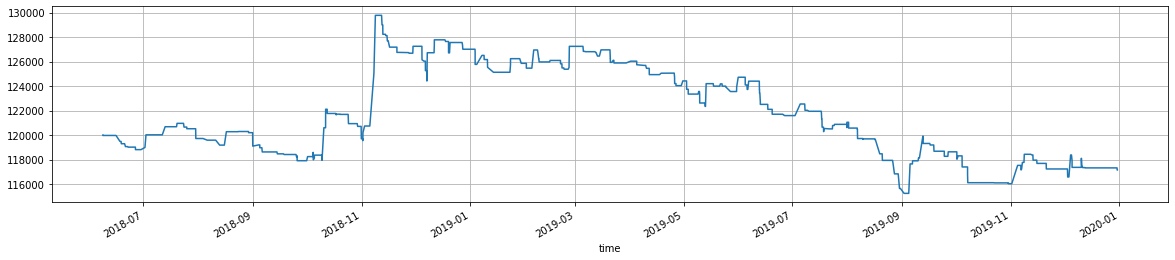

In [10]:
df.cash.plot(figsize=(20,4), grid=True);

In [11]:
by_contract = pd.pivot_table(df, values='realizedPNL', index=df.index, columns=['contract'])
by_contract['total'] = by_contract.sum(axis=1)

In [12]:
# number of trades
trades = df.groupby('contract').action.count()
trades, trades.sum()

(contract
 ES    133
 GC    142
 NQ     62
 YM     76
 Name: action, dtype: int64,
 413)

In [13]:
# trades per day
days = len(by_contract.resample('B').count().index)
trades/days, trades.sum()/days

(contract
 ES    0.326781
 GC    0.348894
 NQ    0.152334
 YM    0.186732
 Name: action, dtype: float64,
 1.0147420147420148)

In [14]:
# commission paid
df.groupby('contract').commission.sum()

contract
ES    279.30
GC    343.64
NQ    130.20
YM    159.60
Name: commission, dtype: float64

In [15]:
df.commission.sum()

912.74

In [16]:
# per trade stats
exits = df[df.realizedPNL!=0]
dfs = {}
for contract in exits.contract.unique():
    dfs[contract] = exits[exits.contract == contract]
dfs['total'] = exits
results = pd.DataFrame(columns=['success_rate', 'average_PNL', 'average_gain', 'average_loss','win_ratio', 'EV',
                               'number_of_positions'])
for c, d in dfs.items():
    row = pd.Series()
    row['success_rate'] = round((d[d.realizedPNL > 0]).realizedPNL.count() / d.realizedPNL.count(), 2)
    row['average_PNL'] = round(d.realizedPNL.mean(), 2)
    row['average_gain'] = round((d[d.realizedPNL > 0]).realizedPNL.mean(), 2)
    row['average_loss'] = round((d[d.realizedPNL < 0]).realizedPNL.mean(), 2)
    row['win_ratio'] = round(abs(row['average_gain'] / row['average_loss']), 2)
    row['EV'] = round((row['average_gain'] * row['success_rate']) + (
        row['average_loss'] * (1 - row['success_rate'])), 2)
    row['number_of_positions'] = d.realizedPNL.count()
    results.loc[c] = row
results

,success_rate,average_PNL,average_gain,average_loss,win_ratio,EV,number_of_positions
NQ,0.26,-46.62,506.42,-238.98,2.12,-45.18,31.0
YM,0.29,46.85,1028.07,-352.90,2.91,47.58,38.0
GC,0.32,-62.02,342.12,-255.67,1.34,-64.38,71.0
ES,0.33,18.53,1085.00,-514.71,2.11,13.19,66.0
total,0.31,-13.81,735.92,-351.72,2.09,-14.55,206.0


In [17]:
daily = by_contract.resample('B').sum()
daily = daily /  (allocs * cash)
#daily[['CL', 'ES', 'GC', 'NQ']].plot(figsize=(20,8), grid=True);

In [18]:
# instrument correlations
log_returns = np.log(daily + 1)
log_returns.corr()

,ES,GC,NQ,YM,total
ES,1.000000,-0.035762,-0.022894,0.026137,0.757083
GC,-0.035762,1.000000,0.008213,0.024189,0.250684
NQ,-0.022894,0.008213,1.000000,0.032848,0.217625
YM,0.026137,0.024189,0.032848,1.000000,0.576812
total,0.757083,0.250684,0.217625,0.576812,1.000000


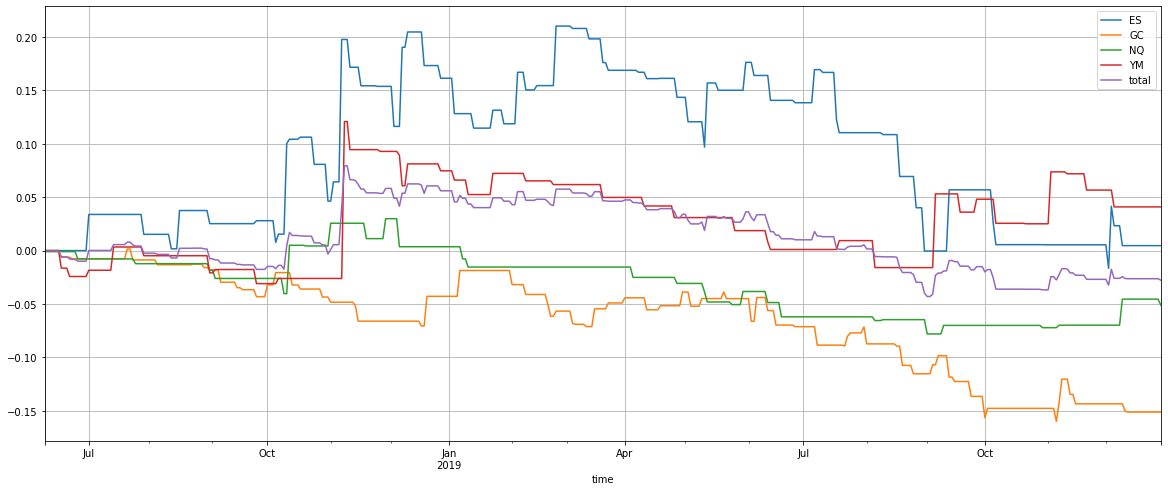

In [19]:
log_returns.cumsum().plot(figsize=(20,8), grid=True);

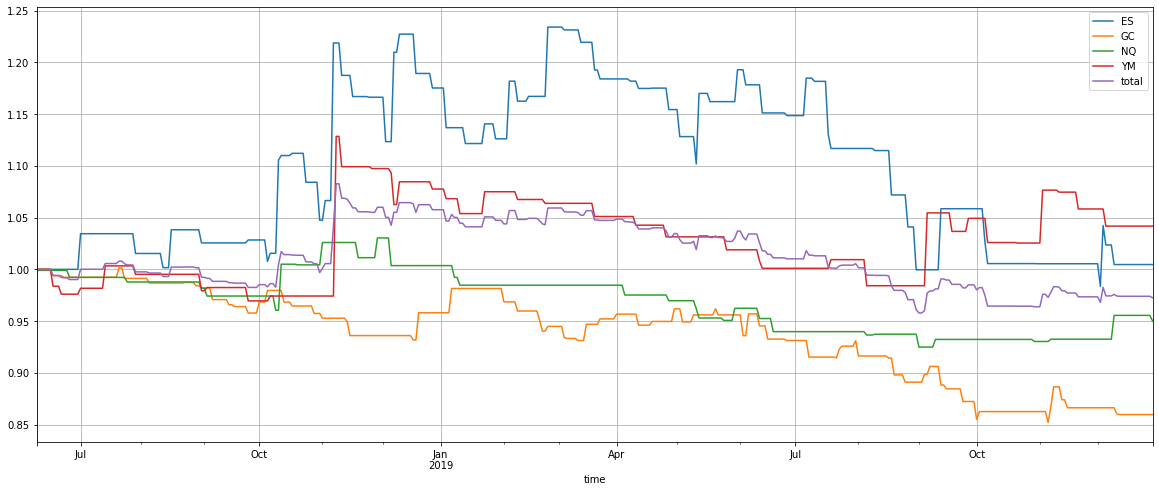

In [20]:
returns = daily.copy()
returns_index = (returns + 1).cumprod()
returns_index.plot(figsize=(20,8), grid=True);

In [21]:
stats = pd.DataFrame()
for col in daily.columns:
    stats[col] = perf_stats(daily[col])
stats

,ES,GC,NQ,YM,total
Annual return,0.002874,-0.089413,-0.031175,0.025667,-0.017046
Cumulative returns,0.004645,-0.140391,-0.049865,0.041781,-0.027386
Annual volatility,0.215841,0.074448,0.061095,0.156487,0.071304
Sharpe ratio,0.116925,-1.220795,-0.488212,0.234815,-0.205915
Calmar ratio,0.014152,-0.599436,-0.304546,0.200695,-0.147854
Stability,0.002617,0.814506,0.679920,0.082928,0.127239
Max drawdown,-0.203058,-0.149162,-0.102365,-0.127891,-0.115290
Omega ratio,1.054013,0.633259,0.737074,1.186852,0.938446
Sortino ratio,0.231974,-1.641435,-0.804933,0.648801,-0.383807
Skew,4.511938,0.419786,4.382123,11.258734,3.567052


In [22]:
# monthly returns in percent
monthly_log_returns = log_returns.resample('M').sum()
monthly_returns = np.exp(monthly_log_returns)-1
round(monthly_returns, 4) * 100

,ES,GC,NQ,YM,total
time,,,,,
2018-06-30,0.00,-0.76,-0.78,-2.40,-0.99
2018-07-31,1.53,-0.11,-0.45,1.96,0.75
2018-08-31,1.01,-0.93,-0.61,-1.60,-0.52
2018-09-30,0.28,-2.48,-0.76,-1.00,-0.99
2018-10-31,1.85,-0.04,3.09,0.49,1.46
2018-11-30,11.35,-2.23,2.59,12.64,6.34
2018-12-31,0.77,2.36,-2.59,-1.80,-0.23
2019-01-31,-4.18,2.45,-1.89,-0.24,-0.97
2019-02-28,9.58,-3.73,0.00,-1.04,1.14


In [23]:
# total returns by contract in percent
round(np.exp(monthly_log_returns.sum())-1, 2)* 100

ES        0.0
GC      -14.0
NQ       -5.0
YM        4.0
total    -3.0
dtype: float64

In [24]:
df.sort_values('realizedPNL', ascending=False)[['contract', 'action', 'price', 'realizedPNL']]

,contract,action,price,realizedPNL
time,,,,
2018-11-08 16:52:30,YM,SELL,26183.00,4750.8
2018-11-07 21:07:30,ES,SELL,2806.25,4283.3
2018-10-10 17:44:30,ES,BUY,2845.00,2658.3
2018-12-07 21:27:30,ES,BUY,2632.75,2308.3
2019-09-05 09:09:00,YM,SELL,26528.00,2145.8
...,...,...,...,...
2019-01-03 19:17:00,ES,SELL,2456.00,-979.2
2018-10-31 19:17:00,ES,BUY,2736.00,-1016.7
2018-12-04 21:22:30,ES,SELL,2709.00,-1104.2


In [25]:
daily.sort_values('total', ascending=False)

,ES,GC,NQ,YM,total
time,,,,,
2018-11-08,0.000000,0.000000,0.0,0.158360,0.039590
2018-11-07,0.142777,0.000000,0.0,0.000000,0.035694
2018-10-10,0.088610,0.000000,0.0,0.000000,0.022153
2019-09-05,0.000000,0.000000,0.0,0.071527,0.017882
2019-02-25,0.057360,0.004839,0.0,0.000000,0.015550
...,...,...,...,...,...
2019-08-30,-0.039723,0.000000,0.0,0.000000,-0.009931
2019-01-03,-0.032640,0.000000,0.0,-0.008640,-0.010320
2019-10-07,-0.020557,0.000000,0.0,-0.022307,-0.010716
